# The Effect of ALEKS (Math Software) on Mathematics Achivements on STAAR (Texas State Test)

## What is ALEKS?
ALEKS is an artificially intelligent, research-based, online learning and assessment system that offers course products for Math and being used by over 25 million students. ALEKS helps students master course topics through a continuous cycle of mastery, knowledge retention, and positive feedback. Each student begins a new course with a unique set of knowledge and prerequisite gaps to fill. By determining the student's baseline of knowledge, ALEKS creates an individual and dynamic path to success where students learn and then master topics.

## What is STAAR?
STAAR is the state of Texas' testing program and is based on state curriculum standards in core subjects including reading, writing, mathematics, science, and social studies. STAAR tests are designed to measure what students are learning in each grade and whether or not they are ready for the next grade. The goal is to ensure that all students receive what they need to be academically successful. For STAAR, the labels for the performance categories are

- Masters Grade Level
- Meets Grade Level
- Approaches Grade Level
- Did Not Meet Grade Level (Fails)

Students receive one of the above ratings based on their test performance. Schools and districts are rated based on how students score on the State of Texas Assessments of Academic Readiness (STAAR).

## What is the Data Science Problem?
Our 3rd-9th grade students have blended learning time in which students work on completing their ALEKS topic goals. We believe ALEKS helps students improve their math skills and retain their math knowledge. One metric that measure math progress is STAAR test.

Our problem is to be able to project our students STAAR test performances (pass or fail) based on their ALEKS progress.

Our hypothesis is that students who reach certain amount of mastery on ALEKS will likely to pass the STAAR test (receive Approaches grade level or above rating).

## How was Data Collected?
We gathered data by generating ALEKS reports and combining with STAAR test results. During the data cleaning process, some data has been removed due to not missing fileds and duplicates. We also removed confidential columns like student and teacher names, and ID numbers as well as some irrelevant colums. 

### Loading Libraries

In [510]:
import numpy as np
import pandas as pd
from pandas import read_csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, \
roc_auc_score, roc_curve, auc, SCORERS

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import svm 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.utils import resample

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')


pd.set_option('display.max_columns', None)

%matplotlib inline

random_seed = 42

In [34]:
#location of the dataset.
path = "./dataset/ALEKS_2021-22_EOY.xlsx"

In [35]:
# Load dataset
df_original = pd.read_excel(path)

In [36]:
# Make a copy so that we keep the original just in case.
df = df_original.copy()

In [37]:
#Take a look at the data.
df

,School Grade,ALEKS Grade,Campus,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,STAAR Performance
0,7,7,Harmony School of Innovation-Waco,0.125506,31,0.125506,31,247,0.010000,16,897.600000,Meets
1,9,9,Harmony Science Academy-El Paso,0.073654,26,0.073654,26,353,0.010000,20,513.183333,Approaches
2,8,8,Harmony School of Innovation-Garland,0.111570,27,0.111570,27,242,0.010000,35,1375.300000,Approaches
3,6,6,Harmony Science Academy-Garland,0.366013,112,0.366013,112,306,0.010000,74,1886.050000,Approaches
4,5,5,Harmony School of Excellence-San Antonio,0.051587,13,0.055556,14,252,0.010000,13,842.016667,Fails
...,...,...,...,...,...,...,...,...,...,...,...,...
11714,6,9,Harmony School of Discovery-Houston,0.249292,88,2.000000,353,353,1.750708,324,5221.383333,Masters
11715,6,7,Harmony School of Technology-Houston,0.234818,58,2.000000,247,247,1.765182,179,5617.866667,Masters
11716,3,6,Harmony Science Academy-Cedar Park,0.233696,43,2.000000,184,184,1.766304,144,1174.400000,Meets
11717,4,5,Harmony School of Innovation-Carrollton,0.181818,30,1.957576,158,165,1.775758,133,1528.883333,Masters


## Explanation of Features
- <b>School Grade:</b> Students current math grade
- <b>ALEKS Grade:</b> Some students can be placed in lower or higher than their school grade in ALEKS depending on their needs.
- <b>Campus:</b> School name
- <b>BOY Mastery:</b> What percentage of total topics a student mastered at the begining of the school year during the initial knowledge check.
- <b>BOY Mastered Topics:</b> How many topics a student mastered at the begining of the school year during the initial knowledge check. 
- <b>EOY Mastery:</b> What percentage of total topics a student mastered by the end of the school year.
- <b>EOY Mastered Topics:</b> How many topics a student mastered by the end of the school year.
- <b>Total Number of Topics:</b> Total number of topics available in student's ALEKS course.
- <b>Progress:</b> The difference between EOY and BOY Mastery.
- <b>Learned:</b> How many topics a student learn during the coursework.
- <b>Attempted:</b> How many topics a student attempted to learn during the coursework.
- <b>Total Time Spent:</b> How much time in minutes a student spent on ALEKS during the entire coursework.
- <b>STAAR Performance:</b> Performance category of a student based on STAAR test result.

In [6]:
#Data Types
df.dtypes

School Grade                int64
ALEKS Grade                 int64
Campus                     object
BOY Mastery               float64
BOY Mastered Topics         int64
EOY Mastery               float64
EOY Mastered Topics         int64
Total Number of Topics      int64
Progress                  float64
Learned                     int64
Total Time Spent          float64
STAAR Performance          object
dtype: object

In [38]:
#We need to encode target values. We are only interested in pass/fail status.
df["Target"] = df["STAAR Performance"].map({"Fails":0, "Approaches":1, "Meets":1, "Masters":1})
df

,School Grade,ALEKS Grade,Campus,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,STAAR Performance,Target
0,7,7,Harmony School of Innovation-Waco,0.125506,31,0.125506,31,247,0.010000,16,897.600000,Meets,1
1,9,9,Harmony Science Academy-El Paso,0.073654,26,0.073654,26,353,0.010000,20,513.183333,Approaches,1
2,8,8,Harmony School of Innovation-Garland,0.111570,27,0.111570,27,242,0.010000,35,1375.300000,Approaches,1
3,6,6,Harmony Science Academy-Garland,0.366013,112,0.366013,112,306,0.010000,74,1886.050000,Approaches,1
4,5,5,Harmony School of Excellence-San Antonio,0.051587,13,0.055556,14,252,0.010000,13,842.016667,Fails,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11714,6,9,Harmony School of Discovery-Houston,0.249292,88,2.000000,353,353,1.750708,324,5221.383333,Masters,1
11715,6,7,Harmony School of Technology-Houston,0.234818,58,2.000000,247,247,1.765182,179,5617.866667,Masters,1
11716,3,6,Harmony Science Academy-Cedar Park,0.233696,43,2.000000,184,184,1.766304,144,1174.400000,Meets,1
11717,4,5,Harmony School of Innovation-Carrollton,0.181818,30,1.957576,158,165,1.775758,133,1528.883333,Masters,1


## Do we have a balanced or imbalanced dataset?

In [311]:
print('The percentage of "0" cases is {:.1f}%'.format((df.Target.value_counts()[0]/df.shape[0])*100))

The percentage of "0" cases is 25.8%


Only 26% of the data belongs to class 0 and 74% belongs to class 1. So, we have an imbalanced dataset.

## Train and Test Data Split

It is very important to split the test data before data preprocessing steps to avoid data leakage!

We will set aside our test data and only use training data first. Then we will take similar preprocessing steps for test data.

In [39]:
#X values
X = df.drop(columns=["Campus","STAAR Performance","Target"])
X

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent
0,7,7,0.125506,31,0.125506,31,247,0.010000,16,897.600000
1,9,9,0.073654,26,0.073654,26,353,0.010000,20,513.183333
2,8,8,0.111570,27,0.111570,27,242,0.010000,35,1375.300000
3,6,6,0.366013,112,0.366013,112,306,0.010000,74,1886.050000
4,5,5,0.051587,13,0.055556,14,252,0.010000,13,842.016667
...,...,...,...,...,...,...,...,...,...,...
11714,6,9,0.249292,88,2.000000,353,353,1.750708,324,5221.383333
11715,6,7,0.234818,58,2.000000,247,247,1.765182,179,5617.866667
11716,3,6,0.233696,43,2.000000,184,184,1.766304,144,1174.400000
11717,4,5,0.181818,30,1.957576,158,165,1.775758,133,1528.883333


In [40]:
#y values
y = df["Target"]
y

0        1
1        1
2        1
3        1
4        0
        ..
11714    1
11715    1
11716    1
11717    1
11718    1
Name: Target, Length: 11719, dtype: int64

Let's see if we have a balanced dataset.

In [41]:
#Train and test data split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size=0.8, random_state=random_seed)

In [42]:
#Let's take a look at the shape
(X_train.shape, X_test.shape)

((9375, 10), (2344, 10))

In [43]:
#create a dataframe of trainging data including the target values for EDA and visualization
df_train = X_train.copy()
df_train["Target"] = Y_train

In [44]:
#reseting index values
df_train.reset_index(drop=True, inplace=True)
df_train

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target
0,9,9,0.099150,35,0.750708,265,353,0.651558,218,2750.700000,1
1,5,5,0.095238,24,0.253968,64,252,0.158730,56,1676.616667,0
2,3,3,0.445652,41,0.967391,89,92,0.521739,59,840.216667,1
3,4,4,0.000000,0,0.178571,45,252,0.178571,70,1569.933333,0
4,5,5,0.253968,64,0.611111,154,252,0.357143,110,1579.483333,1
...,...,...,...,...,...,...,...,...,...,...,...
9370,3,5,0.609195,159,1.896552,234,261,1.287356,85,1575.483333,1
9371,6,6,0.009804,3,0.297386,91,306,0.287582,125,2030.900000,0
9372,3,3,0.000000,0,0.301136,53,176,0.301136,62,1072.866667,0
9373,6,6,0.035948,11,0.114379,35,306,0.078431,24,777.800000,0


In [45]:
#checking missing values
df_train.isna().sum()

School Grade              0
ALEKS Grade               0
BOY Mastery               0
BOY Mastered Topics       0
EOY Mastery               0
EOY Mastered Topics       0
Total Number of Topics    0
Progress                  0
Learned                   0
Total Time Spent          0
Target                    0
dtype: int64

In [46]:
#create a dataframe of testing data including the target values for EDA and visualization
df_test = X_test.copy()
df_test["Target"] = Y_test
df_test

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target
101,6,6,0.022876,7,0.049020,15,306,0.026144,12,339.966667,0
5271,6,6,0.042484,13,0.336601,103,306,0.294118,92,1760.516667,1
5146,4,4,0.190202,66,0.475504,165,347,0.285303,112,1748.416667,1
9219,3,3,0.358696,33,0.989130,91,92,0.630435,72,1069.366667,1
1845,7,7,0.072874,18,0.198381,49,247,0.125506,37,489.800000,1
...,...,...,...,...,...,...,...,...,...,...,...
3116,9,9,0.110701,60,0.293358,159,542,0.182657,89,4016.683333,0
2199,7,7,0.085020,21,0.226721,56,247,0.141700,72,1070.950000,0
2503,4,4,0.422680,82,0.577320,112,194,0.154639,29,1268.850000,0
4194,6,6,0.477124,146,0.712418,218,306,0.235294,71,857.133333,1


## EDA and Visualization

In [47]:
df_train.describe()

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target
count,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000,9375.000000
mean,6.131093,6.276053,0.182286,57.014187,0.620316,145.900373,296.035200,0.438037,104.352427,1871.136590,0.740800
std,1.991230,1.999989,0.170929,66.894774,0.455455,97.389451,111.528648,0.356982,81.565921,1352.090297,0.438219
min,3.000000,3.000000,0.000000,0.000000,0.005666,2.000000,46.000000,0.005666,1.000000,300.000000,0.000000
25%,4.000000,5.000000,0.049020,13.000000,0.289256,71.000000,242.000000,0.175637,43.000000,866.091667,0.000000
50%,6.000000,6.000000,0.127451,34.000000,0.515581,125.000000,254.000000,0.330065,82.000000,1565.683333,1.000000
75%,8.000000,8.000000,0.269841,74.000000,0.794595,203.000000,353.000000,0.578696,145.000000,2510.691667,1.000000
max,9.000000,11.000000,0.979381,543.000000,2.000000,909.000000,920.000000,1.766304,587.000000,13411.483333,1.000000


In [48]:
#correlation matrix
df_train.corr()

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target
School Grade,1.000000,0.973330,-0.208268,0.041657,-0.217535,0.153210,0.574057,-0.177796,0.147183,0.214281,0.186505
ALEKS Grade,0.973330,1.000000,-0.108516,0.149140,-0.048929,0.216933,0.629998,-0.010444,0.128143,0.167515,0.234163
BOY Mastery,-0.208268,-0.108516,1.000000,0.850134,0.701424,0.570563,0.160060,0.416090,0.011513,-0.115815,0.286687
BOY Mastered Topics,0.041657,0.149140,0.850134,1.000000,0.640949,0.748768,0.561648,0.410693,0.113443,-0.041645,0.272336
EOY Mastery,-0.217535,-0.048929,0.701424,0.640949,1.000000,0.644223,0.177805,0.939971,0.262756,0.037418,0.354977
EOY Mastered Topics,0.153210,0.216933,0.570563,0.748768,0.644223,1.000000,0.598129,0.548713,0.659344,0.381417,0.368535
Total Number of Topics,0.574057,0.629998,0.160060,0.561648,0.177805,0.598129,1.000000,0.150217,0.282669,0.122344,0.221571
Progress,-0.177796,-0.010444,0.416090,0.410693,0.939971,0.548713,0.150217,1.000000,0.329706,0.103181,0.315626
Learned,0.147183,0.128143,0.011513,0.113443,0.262756,0.659344,0.282669,0.329706,1.000000,0.670765,0.210404
Total Time Spent,0.214281,0.167515,-0.115815,-0.041645,0.037418,0.381417,0.122344,0.103181,0.670765,1.000000,0.057438


In [69]:
#let's round the numbers up to 2 decimal places
fig = px.imshow(df_train.corr().round(2), text_auto=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show()

It seems that there is some type of correlation between Target values and EOY Mastered Topics, EOY Mastery, and Progress.

### ALEKS Performace by STAAR Ratings

In [54]:
#Let's take a look at the avarege ALEKS performances by STAAR ratings.
df_new = df.groupby("STAAR Performance", as_index=False).mean()
df_new.sort_values(by=["Progress"], inplace=True)
df_new.reset_index(drop=True, inplace=True)
df_new

,STAAR Performance,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target
0,Fails,5.499175,5.481677,0.098385,25.760977,0.345371,84.550017,254.091779,0.246993,75.027402,1726.626896,0.0
1,Approaches,6.087448,6.083284,0.144783,40.482748,0.463920,126.024093,281.182629,0.319150,103.671921,1984.748939,1.0
2,Meets,6.233803,6.414085,0.219267,68.414085,0.738133,169.247887,304.512676,0.518870,117.207243,1943.140966,1.0
3,Masters,6.729511,7.185719,0.283454,99.848048,0.991198,215.672177,350.616954,0.707753,126.559620,1828.738393,1.0


## Number of Topics Completed by STAAR Performance

In [78]:
fig1 = px.pie(df_new, values='EOY Mastered Topics', names='STAAR Performance', 
              color='STAAR Performance', title='Number of Topics Completed by Performance')

fig1.update_traces(textposition='inside', textinfo='percent+label')
fig1.show()

As you see, students who "Fail" the STAAR test are accountable for only 14% of topics mastered by all students. On the other hand, students who "Master" the STAAR are responsible for the biggest chunk: 36%  of all topics mastered.

We can also observe strong relationship between number of topics mastered and STAAR Performances.

## ALEKS Progress by STAAR Performance

In [79]:
fig2 = px.pie(df_new, values='Progress', names='STAAR Performance', 
              color='STAAR Performance', title='ALEKS Progress by STAAR Performance')

fig2.update_traces(textposition='inside', textinfo='percent+label')
fig2.show()

This is really alligned with the above chart. Students who show less progress on ALEKS perform lower on STAAR test.

## Total Time Spent by STAAR Performance

In [80]:
fig3 = px.pie(df_new, values='Total Time Spent', names='STAAR Performance', 
              color='STAAR Performance', title='Total Time Spent by Performance')

fig3.update_traces(textposition='inside', textinfo='percent+label')
fig3.show()

It seems students spend similar amount of times on ALEKS, but they show different progress. That means, it takes different amount of time for students to master a topic on ALEKS. So, let's take a look at the learning rate of each group. 

## Learning Rate

In [58]:
#Let's calculate and add a learning rate column. (Number of topic a student learns per hour)
#Since time values are based on minutes, I will divide the total time by 60 (or multiply the numerator by 60 instead).
df_new["Learning Rate"] = df_new["Learned"]*60/(df_new["Total Time Spent"])

#Let's drop some columns.
df_new = df_new.drop(columns=["School Grade","ALEKS Grade","Target"])
df_new

,STAAR Performance,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Learning Rate
0,Fails,0.098385,25.760977,0.345371,84.550017,254.091779,0.246993,75.027402,1726.626896,2.607190
1,Approaches,0.144783,40.482748,0.463920,126.024093,281.182629,0.319150,103.671921,1984.748939,3.134056
2,Meets,0.219267,68.414085,0.738133,169.247887,304.512676,0.518870,117.207243,1943.140966,3.619107
3,Masters,0.283454,99.848048,0.991198,215.672177,350.616954,0.707753,126.559620,1828.738393,4.152358


In [81]:
fig4 = px.pie(df_new, values='Learning Rate', names='STAAR Performance', 
              color='STAAR Performance', title='Learning Rate by Performance')

fig4.update_traces(textposition='inside', textinfo='percent+label')
fig4.show()

Again, there is a strong correlation between the STAAR Performance of students and ALEKS topics learning rate, rather than time spent on ALEKS.

## Addding New Feature

In [82]:
# Let's add this new feature to our training and testing data.
df_train["Learning Rate"] = df_train["Learned"]*60/(df_train["Total Time Spent"])
df_train

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target,Learning Rate
0,9,9,0.099150,35,0.750708,265,353,0.651558,218,2750.700000,1,4.755153
1,5,5,0.095238,24,0.253968,64,252,0.158730,56,1676.616667,0,2.004036
2,3,3,0.445652,41,0.967391,89,92,0.521739,59,840.216667,1,4.213199
3,4,4,0.000000,0,0.178571,45,252,0.178571,70,1569.933333,0,2.675273
4,5,5,0.253968,64,0.611111,154,252,0.357143,110,1579.483333,1,4.178582
...,...,...,...,...,...,...,...,...,...,...,...,...
9370,3,5,0.609195,159,1.896552,234,261,1.287356,85,1575.483333,1,3.237102
9371,6,6,0.009804,3,0.297386,91,306,0.287582,125,2030.900000,0,3.692944
9372,3,3,0.000000,0,0.301136,53,176,0.301136,62,1072.866667,0,3.467346
9373,6,6,0.035948,11,0.114379,35,306,0.078431,24,777.800000,0,1.851376


In [84]:
df_test["Learning Rate"] = df_test["Learned"]*60/(df_test["Total Time Spent"])
df_test

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target,Learning Rate
101,6,6,0.022876,7,0.049020,15,306,0.026144,12,339.966667,0,2.117855
5271,6,6,0.042484,13,0.336601,103,306,0.294118,92,1760.516667,1,3.135443
5146,4,4,0.190202,66,0.475504,165,347,0.285303,112,1748.416667,1,3.843477
9219,3,3,0.358696,33,0.989130,91,92,0.630435,72,1069.366667,1,4.039774
1845,7,7,0.072874,18,0.198381,49,247,0.125506,37,489.800000,1,4.532462
...,...,...,...,...,...,...,...,...,...,...,...,...
3116,9,9,0.110701,60,0.293358,159,542,0.182657,89,4016.683333,0,1.329455
2199,7,7,0.085020,21,0.226721,56,247,0.141700,72,1070.950000,0,4.033802
2503,4,4,0.422680,82,0.577320,112,194,0.154639,29,1268.850000,0,1.371320
4194,6,6,0.477124,146,0.712418,218,306,0.235294,71,857.133333,1,4.970055


## Scaling the Data

We need to normalize the data since the features have different scales.

In [85]:
#Let's normalize the training data first.
normal = MinMaxScaler()
df_train_normal = normal.fit_transform(df_train)
df_train_normal = pd.DataFrame(df_train_normal, columns=df_train.columns)
df_train_normal

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target,Learning Rate
0,1.000000,0.750,0.101238,0.064457,0.373580,0.289967,0.351259,0.366851,0.370307,0.186912,1.0,0.045615
1,0.333333,0.250,0.097243,0.044199,0.124504,0.068357,0.235698,0.086937,0.093857,0.104993,0.0,0.019092
2,0.000000,0.000,0.455034,0.075506,0.482229,0.095921,0.052632,0.293117,0.098976,0.041202,1.0,0.040390
3,0.166667,0.125,0.000000,0.000000,0.086698,0.047409,0.235698,0.098206,0.117747,0.096857,0.0,0.025563
4,0.333333,0.250,0.259315,0.117864,0.303583,0.167585,0.235698,0.199630,0.186007,0.097585,1.0,0.040057
...,...,...,...,...,...,...,...,...,...,...,...,...
9370,0.000000,0.250,0.622021,0.292818,0.948129,0.255788,0.245995,0.727969,0.143345,0.097280,1.0,0.030980
9371,0.500000,0.375,0.010010,0.005525,0.146274,0.098126,0.297483,0.160121,0.211604,0.132014,0.0,0.035375
9372,0.000000,0.000,0.000000,0.000000,0.148155,0.056229,0.148741,0.167820,0.104096,0.058946,0.0,0.033200
9373,0.500000,0.375,0.036705,0.020258,0.054511,0.036384,0.297483,0.041329,0.039249,0.036441,0.0,0.017620


In [86]:
#Let's normalize the testing data next.
normal = MinMaxScaler()
df_test_normal = normal.fit_transform(df_test)
df_test_normal = pd.DataFrame(df_test_normal, columns=df_test.columns)
df_test_normal

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Target,Learning Rate
0,0.500000,0.375,0.025064,0.011309,0.017552,0.011198,0.274232,0.011336,0.020677,0.003096,0.0,0.035993
1,0.500000,0.375,0.046547,0.021002,0.162368,0.109742,0.274232,0.158184,0.171053,0.112640,1.0,0.054509
2,0.166667,0.125,0.208395,0.106624,0.232315,0.179171,0.322695,0.153353,0.208647,0.111707,1.0,0.067393
3,0.000000,0.000,0.393006,0.053312,0.490960,0.096305,0.021277,0.342482,0.133459,0.059343,1.0,0.070965
4,0.666667,0.500,0.079845,0.029079,0.092765,0.049272,0.204492,0.065786,0.067669,0.014650,1.0,0.079930
...,...,...,...,...,...,...,...,...,...,...,...,...
2339,1.000000,0.750,0.121290,0.096931,0.140593,0.172452,0.553191,0.097104,0.165414,0.286622,0.0,0.021646
2340,0.666667,0.500,0.093153,0.033926,0.107036,0.057111,0.204492,0.074660,0.133459,0.059465,0.0,0.070856
2341,0.166667,0.125,0.463111,0.132472,0.283586,0.119821,0.141844,0.081751,0.052632,0.074726,0.0,0.022408
2342,0.500000,0.375,0.522762,0.235864,0.351617,0.238522,0.274232,0.125949,0.131579,0.042977,1.0,0.087893


## Modeling the Data

In [475]:
#Models that will be used
model_list = [LogisticRegression, GaussianNB, DecisionTreeClassifier, LinearSVC, KNeighborsClassifier,
              RandomForestClassifier, GradientBoostingClassifier, SGDClassifier, XGBClassifier,
             LGBMClassifier, LinearDiscriminantAnalysis, AdaBoostClassifier]

#Name of the models
model_names = ['Logistic Regression', 'Gaussian Naive Bayes', 'Decision Tree Classifier', 'Linear SVC', 
               'KNeighbors Classifier', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'SGD Classifier',
              'XGB Classifier', 'LGBM Classifier','Linear Discriminant Analysis','AdaBoost Classifier']

Let's create a function that takes the training set as input and gives the accuracy of each model as output.

In [471]:
def train_clf_model(clf_list, clf_names, x_train, y_train):
    """
    This function returns the accuracy scores of the training data for each models used, in descending order.

    Parameters
    ----------
    clf_list : list
        List of the models to be used.
    clf_names : list
        List of the model names.
    x_train : dataframe values
        Feature values of the training set.
    y_train : list
        Target values of the training set.
        
    Returns
    -------
    Pandas DataFrame
        Accuracy scores of the training data for each model.
    """    
    
    training_scores = []
    
    for index, clf in enumerate(clf_list):
        model = clf()
         
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=random_seed) #StratifiedKFold(n_splits=4, shuffle=True)
        
        #keep the mean of cross validation scores of the training set
        scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv)
        training_scores.append(scores.mean())
    
    #create a dataframe to present results
    data = {'Classifier Names': clf_names,
            'Accuracy Score': training_scores}
    
    #maximum 4 decimal points should be sufficient to compare score values
    pd.options.display.float_format = '{:.4f}'.format
    df = pd.DataFrame(data)
    
    return df.sort_values(by='Accuracy Score', ascending=False).reset_index(drop=True)

In [118]:
X_train = df_train_normal.drop(columns="Target")
X_train

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Learning Rate
0,1.0000,0.7500,0.1012,0.0645,0.3736,0.2900,0.3513,0.3669,0.3703,0.1869,0.0456
1,0.3333,0.2500,0.0972,0.0442,0.1245,0.0684,0.2357,0.0869,0.0939,0.1050,0.0191
2,0.0000,0.0000,0.4550,0.0755,0.4822,0.0959,0.0526,0.2931,0.0990,0.0412,0.0404
3,0.1667,0.1250,0.0000,0.0000,0.0867,0.0474,0.2357,0.0982,0.1177,0.0969,0.0256
4,0.3333,0.2500,0.2593,0.1179,0.3036,0.1676,0.2357,0.1996,0.1860,0.0976,0.0401
...,...,...,...,...,...,...,...,...,...,...,...
9370,0.0000,0.2500,0.6220,0.2928,0.9481,0.2558,0.2460,0.7280,0.1433,0.0973,0.0310
9371,0.5000,0.3750,0.0100,0.0055,0.1463,0.0981,0.2975,0.1601,0.2116,0.1320,0.0354
9372,0.0000,0.0000,0.0000,0.0000,0.1482,0.0562,0.1487,0.1678,0.1041,0.0589,0.0332
9373,0.5000,0.3750,0.0367,0.0203,0.0545,0.0364,0.2975,0.0413,0.0392,0.0364,0.0176


In [90]:
Y_train = df_train_normal["Target"]
Y_train

0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
9370    1.0
9371    0.0
9372    0.0
9373    0.0
9374    1.0
Name: Target, Length: 9375, dtype: float64

In [120]:
X_test = df_test_normal.drop(columns="Target")
X_test

,School Grade,ALEKS Grade,BOY Mastery,BOY Mastered Topics,EOY Mastery,EOY Mastered Topics,Total Number of Topics,Progress,Learned,Total Time Spent,Learning Rate
0,0.5000,0.3750,0.0251,0.0113,0.0176,0.0112,0.2742,0.0113,0.0207,0.0031,0.0360
1,0.5000,0.3750,0.0465,0.0210,0.1624,0.1097,0.2742,0.1582,0.1711,0.1126,0.0545
2,0.1667,0.1250,0.2084,0.1066,0.2323,0.1792,0.3227,0.1534,0.2086,0.1117,0.0674
3,0.0000,0.0000,0.3930,0.0533,0.4910,0.0963,0.0213,0.3425,0.1335,0.0593,0.0710
4,0.6667,0.5000,0.0798,0.0291,0.0928,0.0493,0.2045,0.0658,0.0677,0.0147,0.0799
...,...,...,...,...,...,...,...,...,...,...,...
2339,1.0000,0.7500,0.1213,0.0969,0.1406,0.1725,0.5532,0.0971,0.1654,0.2866,0.0216
2340,0.6667,0.5000,0.0932,0.0339,0.1070,0.0571,0.2045,0.0747,0.1335,0.0595,0.0709
2341,0.1667,0.1250,0.4631,0.1325,0.2836,0.1198,0.1418,0.0818,0.0526,0.0747,0.0224
2342,0.5000,0.3750,0.5228,0.2359,0.3516,0.2385,0.2742,0.1259,0.1316,0.0430,0.0879


In [93]:
Y_test = df_test_normal["Target"]
Y_test

0      0.0000
1      1.0000
2      1.0000
3      1.0000
4      1.0000
        ...  
2339   0.0000
2340   0.0000
2341   0.0000
2342   1.0000
2343   1.0000
Name: Target, Length: 2344, dtype: float64

In [472]:
train_clf_model(model_list, model_names, X_train, Y_train)

,Classifier Names,Accuracy Score
0,Gradient Boosting Classifier,0.8331
1,LGBM Classifier,0.8331
2,AdaBoost Classifier,0.8271
3,Random Forest Classifier,0.8271
4,KNeighbors Classifier,0.8234
5,XGB Classifier,0.8227
6,Linear SVC,0.8020
7,Logistic Regression,0.7987
8,Linear Discriminant Analysis,0.7963
9,SGD Classifier,0.7936


Gradient Boosting Classifier has the highest accuracy.


### Hyperparameter Tuning with Grid Search

In [490]:
params = {
#     'n_estimators':range(100,1000,100),
#     'subsample':[0.6,0.7,0.75,0.8,0.85,0.9, 1.0],
#     'max_features':range(1,10),
#     'min_samples_split':range(1,10),
#     'min_samples_leaf':range(1,10),
    'max_depth':range(1,10),
}
gsearch = GridSearchCV(estimator = GradientBoostingClassifier(), 
param_grid = params, scoring='accuracy',n_jobs=2, cv=5)
gsearch.fit(X_train, Y_train)
gsearch.best_params_, gsearch.best_score_

({'max_depth': 5}, 0.8344533333333333)

So, max_depth=5 will give us better score than the default value of 3.

We have tried to optimize other parameters but they did not improve the model accuracy.

In [504]:
#model selection
model_1 = GradientBoostingClassifier()
model = GradientBoostingClassifier(max_depth=5)

#fitting it on the training set
model_1.fit(X_train, Y_train)
model.fit(X_train, Y_train)

#predict the y values based on X_test with and without the hyperparameter tuning:
y_pred_1 = model_1.predict(X_test)
y_pred = model.predict(X_test)    

#accuracy of the test set
print('The accuracy score without hyperparameter optimization is {:.2f}%'.format(accuracy_score(Y_test, y_pred_1)*100))
print('The accuracy score with the hyperparameter optimization is {:.2f}%'.format(accuracy_score(Y_test, y_pred)*100))

The accuracy score without hyperparameter optimization is 82.85%
The accuracy score with the hyperparameter optimization is 83.23%


The accuracy went up by 0.4% with the hyperparameter optimization.

### Confusion Matrix

Let's take a look at the Confusion Matrix.

Confusion Matrix:
[[ 380  219]
 [ 174 1571]]


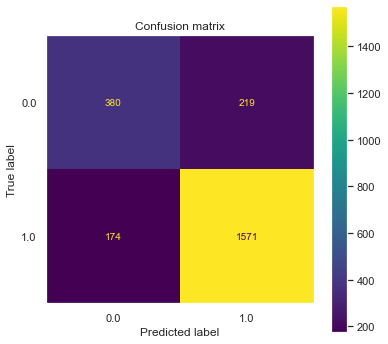

              precision    recall  f1-score   support

         0.0       0.69      0.63      0.66       599
         1.0       0.88      0.90      0.89      1745

    accuracy                           0.83      2344
   macro avg       0.78      0.77      0.77      2344
weighted avg       0.83      0.83      0.83      2344



In [520]:
print("Confusion Matrix:")
cm = confusion_matrix(Y_test, y_pred)
print(cm)

plot_confusion_matrix(model, X_test, Y_test)  
#ConfusionMatrixDisplay.from_predictions(Y_test, y_pred)
plt.title('Confusion matrix')
#plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.rcParams["figure.figsize"]=(6,6)
plt.grid(False)
plt.show()
print(classification_report(Y_test, y_pred))

Our model seems to predict one class better than other due to imbalanced target values.
Let's take a look at the feature importances:

In [506]:
model.feature_importances_

array([0.03255987, 0.19570894, 0.04636211, 0.02812671, 0.18113919,
       0.24337241, 0.07580116, 0.03990442, 0.03353915, 0.08398665,
       0.03949939])

Text(0.5, 0, 'Feature Importance')

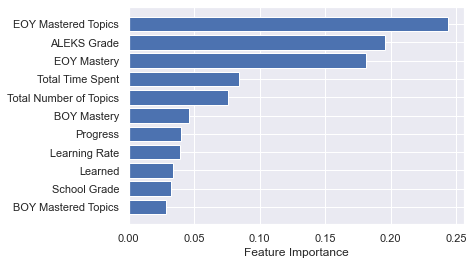

In [507]:
#Let's look at feature importances
features = X_test.columns
sorted_idx = model.feature_importances_.argsort()
plt.barh(features[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Feature Importance")

### Findings

So, the number of topics mastered by students at the end of the year is the most important feature to predict students' STAAR pass/fail determination. We predict that the more topics student mastered, the more likely they pass the STAAR. 

Second most important factor is the ALEKS grade. That means students who work on upper grade level math subjects perform better on the STAAR than other students.

Third important feature is End of Year Mastery Percentage. Students with higher mastery percentage tend to do better on STAAR.

### Different Tresholds

We would like to predict students who will fail STAAR (0 cases) as much as possible because our goal is to identify potential students who will likely to fail STAAR test based on their ALEKS performance. That way, we can intervene earlier.

That requires higher Recall scores rather than Precision since we would like to catch as much relevant instances as possible. 

We can ply with the treshold value to increase recall of 0 cases.

In [521]:
threshold = 0.62
y_pred = (model.predict_proba(X_test)[:, 1] > threshold).astype('float')
print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

[[ 451  148]
 [ 262 1483]]
              precision    recall  f1-score   support

         0.0       0.63      0.75      0.69       599
         1.0       0.91      0.85      0.88      1745

    accuracy                           0.83      2344
   macro avg       0.77      0.80      0.78      2344
weighted avg       0.84      0.83      0.83      2344



As you see, without changing the accuracy score (still 83%), we were able to increase recall of 0 cases by changing the treshold from default 0.5 to 0.62. Now, our model cathces 451 of 599 true positive cases as opposed to 380 over 599.

## Dimensionality Reduction with PCA

Let's try Principal Component Analysis to see of it helps model perform better.

In [572]:
# Generate all the principal components
pca = PCA()
X_train_pc = pca.fit_transform(X_train)
# X_test_pc = pca.transform(X_test)
np.set_printoptions(suppress=True)
print(pca.explained_variance_ratio_)

[0.49273665 0.32040925 0.08232128 0.06034154 0.02515731 0.01123495
 0.00341417 0.00211674 0.0013453  0.0009228  0.00000002]


Let's visualize the PCA with 2 components.

In [568]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['red', 'green']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m,
            edgecolor='none', alpha=0.5
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.show()

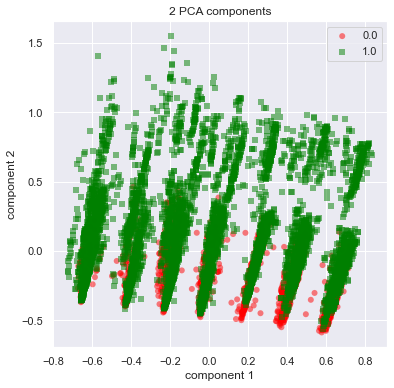

In [604]:
plot_2d_space(X_train_pc, Y_train, '2 PCA components')

### Choosing the number of components

Text(0, 0.5, 'cumulative explained variance')

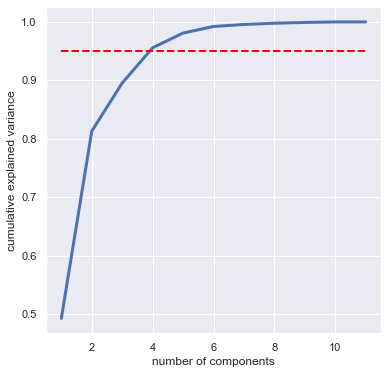

In [602]:
plt.plot(range(1,12), np.cumsum(pca.explained_variance_ratio_), lw=3)
plt.plot([1, 11], [0.95, 0.95], color="red", lw=2, linestyle="--")
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

As you see, 4 components contain approximately 95% of the variance.

In [603]:
pca = PCA(n_components=4)

X_train_pc = pca.fit_transform(X_train)

model.fit(X_train_pc, Y_train)

X_test_pc = pca.transform(X_test)

y_pred_pc = model.predict(X_test_pc) 

#accuracy of the test set
print('The accuracy score with PCA is {:.2f}%'.format(accuracy_score(Y_test, y_pred_pc)*100))

The accuracy score with PCA is 82.30%


### PCA with Kernel

Let's try PCA with RBF Kernel.

In [605]:
kpca = KernelPCA(n_components=4, kernel ='rbf')
X_train_kpca = kpca.fit_transform(X_train)

model.fit(X_train_kpca, Y_train)

X_test_kpca = kpca.transform(X_test)

#predict the y values based on X_test with and without the hyperparameter tuning:
y_pred_kpca = model.predict(X_test_kpca) 

#accuracy of the test set
print('The accuracy score with PCA is {:.2f}%'.format(accuracy_score(Y_test, y_pred_kpca)*100))

The accuracy score with PCA is 82.51%


The best score with PCA is 82.51% which is close to 83.23%.

## Addressing Imbalanced Classes

In [305]:
# Display class counts
df_train_normal.Target.value_counts()

1.0000    6945
0.0000    2430
Name: Target, dtype: int64

As you see, we have a datasets with a disproportionate ratio of observations in each class. Therefore accuracy score can be a misleading metric to evaluate model performance. Let's try to balance the dataset with 2 different methods.

### 1. Let's Down-sample Majority Class

In [626]:
# Separate majority and minority classes
df_minority = df_train_normal[df_train_normal.Target==0]
df_majority = df_train_normal[df_train_normal.Target==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2430,     # to match minority class
                                 random_state=random_seed) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Target.value_counts()

1.0000    2430
0.0000    2430
Name: Target, dtype: int64

In [627]:
# Separate input features (X) and target variable (y)
y_d = df_downsampled.Target
X_d = df_downsampled.drop('Target', axis=1)

train_clf_model(model_list, model_names, X_d, y_d)

,Classifier Names,Accuracy Score
0,Gradient Boosting Classifier,0.7962
1,LGBM Classifier,0.7905
2,AdaBoost Classifier,0.7886
3,Random Forest Classifier,0.7876
4,XGB Classifier,0.7799
5,KNeighbors Classifier,0.7778
6,Linear SVC,0.7720
7,Logistic Regression,0.7700
8,Linear Discriminant Analysis,0.7638
9,SGD Classifier,0.7578


It seems that the accuracy decreased! Let's predict the testing results.

In [628]:
#model selection
model_d = GradientBoostingClassifier()

#fitting it on the training set
model_d.fit(X_d, y_d)

#predict the y values based on X_test
y_pred_d = model_d.predict(X_test)
        
#accuracy of the test set
print('The accuracy score is {:.2f}%'.format(accuracy_score(Y_test, y_pred_d)*100))

The accuracy score is 78.16%


The accuracy scores actually went down! So downsampling majority class did not work!

### 2. Let's Up-sample Minority Class

In [606]:
df_minority = df_train_normal[df_train_normal.Target==0]
df_majority = df_train_normal[df_train_normal.Target==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6945,    # to match majority class
                                 random_state=random_seed) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Target.value_counts()

1.0000    6945
0.0000    6945
Name: Target, dtype: int64

Now, we have the same number of observations for in each class.

In [620]:
# Separate input features (X) and target variable (y)
y_u = df_upsampled.Target
X_u = df_upsampled.drop('Target', axis=1)

train_clf_model(model_list, model_names, X_u, y_u)

,Classifier Names,Accuracy Score
0,Random Forest Classifier,0.9154
1,Decision Tree Classifier,0.8970
2,XGB Classifier,0.8945
3,LGBM Classifier,0.8651
4,KNeighbors Classifier,0.8339
5,Gradient Boosting Classifier,0.8166
6,AdaBoost Classifier,0.8014
7,Linear SVC,0.7739
8,Logistic Regression,0.7719
9,SGD Classifier,0.7655


The Random Forest Classifier did a better job on the training set after upsampling the minority class!

Let's see the predictions.

In [624]:
#model selection
model_u = RandomForestClassifier()

#fitting it on the training set
model_u.fit(X_u, y_u)

#predict the y values based on X_test with and without the hyperparameter tuning:
y_pred_u = model_u.predict(X_test)    

#accuracy of the test set
print('The accuracy score is {:.2f}%'.format(accuracy_score(Y_test, y_pred_u)*100))

The accuracy score is 83.11%


The accuracy has not improved. 

In [625]:
#Random Forest Confusion Matrix
print("Confusion Matrix for Random Forest Classifier:")
cm = confusion_matrix(Y_test, y_pred_u)
print(cm)
print(classification_report(Y_test, y_pred_u))

Confusion Matrix for Random Forest Classifier:
[[ 377  222]
 [ 174 1571]]
              precision    recall  f1-score   support

         0.0       0.68      0.63      0.66       599
         1.0       0.88      0.90      0.89      1745

    accuracy                           0.83      2344
   macro avg       0.78      0.76      0.77      2344
weighted avg       0.83      0.83      0.83      2344



### Area Under the ROC Curve

Since we have an imbalanced dataset, we can use other performance metrics for evaluating the model.

For a general-purpose metric for classification, Area Under ROC Curve (AUROC) is generally recommended.

AUROC represents the likelihood of the model distinguishing observations from two classes.

In [631]:
#model selection
model = GradientBoostingClassifier(max_depth=5)

#fitting it on the training set
model.fit(X_train, Y_train)

#predict the y values based on X_test with and without the hyperparameter tuning:
y_pred = model.predict(X_test)    

#accuracy of the test set
print('The accuracy score with the hyperparameter optimization is {:.2f}%'.format(accuracy_score(Y_test, y_pred)*100))

The accuracy score with the hyperparameter optimization is 83.28%


In [648]:
predicted = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, predicted[:,1])

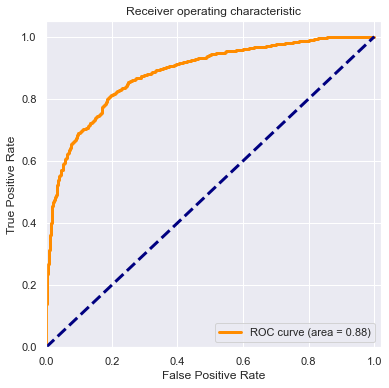

In [649]:
plt.figure()
lw = 3
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_score(Y_test, predicted[:,1]),
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

So, our score now is 88% based on AUROC!

### Precision-Recall curve


Another alternative metric is Precision Recall Curve.

In [652]:
precision, recall, thresholds = precision_recall_curve(Y_test, predicted[:,1])

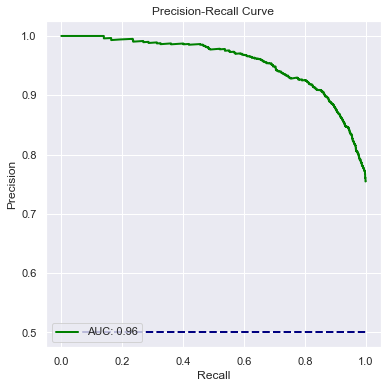

In [655]:
plt.figure()
lw = 2
plt.plot(
    recall,
    precision,
    color="green",
    lw=lw,
    label="AUC: %0.2f" % auc(recall, precision),
)
plt.plot([0, 1], [0.5, 0.5], color="navy", lw=lw, linestyle="--")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

The the area under the Precision-Recall curve is 0.96, so our score is 96%.